<div style="text-align: right">Dino Konstantopoulos, 15 November 2018, with material from Will Koehrsen</div>


## Using Decision Forests to Predict

Can we predict the maximum temperature tomorrow for Boston, given one year of historical data? We're going to use `scikit-learn`'s decision forest implementation.

[Random forests](https://en.wikipedia.org/wiki/Random_forest) are ensemble methods over many trees (1,000 in this lab). Because [decision trees](https://en.wikipedia.org/wiki/Decision_tree_learning) are a greedy optimization method (the next step is just the step that improves an instantaneous metric, not a global metric at the end of the process), you may ask what is different about one tree versus another in the forest. It depends on the forest regression algorithm and how it *ensembles* trees. The most successful ones like [adaboost](https://en.wikipedia.org/wiki/AdaBoost) build new trees based on which previous trees produced low accuracy representations and trying to improve on that, and is often referred to as the best **out-of-the-box classifier**. Most put a limit on the number of features (independent variables) modeled (thus one tree is one subset, and another tree is a different subset of independent variables). Some algorithms also subsample on the data.

<br />
<center>
<img src = ../ipynb.images/maxtemp.gif width = 400 />
</center>

This is a supervised, regression machine learning problem. It’s supervised because we have both the features (data for the city) and the targets (temperature) that we want to predict. During training, we give the random forest both the features and targets and it must learn how to map the data to a prediction. Moreover, this is a regression task because the target value is continuous (as opposed to discrete classes in classification). 
We leverage maximum temperatures in Boston from the National Oceanic and Atmospheric Administration's (NOAA) [Climate Data Online Tool](https://www.ncdc.noaa.gov/cdo-web/)

We are going to do something that is customary with time series: we are going to add duplicate columns with the actual temperature 1, 2, and 3 days ago. We can do it with pandas `Series` and `DataFrame`s, but I found it easier to do in Excel. Name the new columns `temp_1`, `temp_2`, and `temp_3`, respectively.

## 1.Data Acquisition

Note how `temp_2` is the mirror of `temp_1` and a shift downward by one cell. So if today's actual temperature is the column `actual`, `temp_1` was yesterday's temperature, and `temp_2` was the temperature two days ago.

In [533]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as pandas dataframe and display first 5 rows
features = pd.read_csv('../data/boston_temp.csv')
features.head(15)

,year,month,day,week,temp_2,temp_1,TAVG,Actual
0,2019,1,1,Tue,59,59,47,59
1,2019,1,2,Wed,37,59,33,37
2,2019,1,3,Thu,59,37,38,46
3,2019,1,4,Fri,37,46,40,48
4,2019,1,5,Sat,46,48,41,43
5,2019,1,6,Sun,48,43,40,47
6,2019,1,7,Mon,43,47,26,31
7,2019,1,8,Tue,47,31,34,43
8,2019,1,9,Wed,31,43,40,46
9,2019,1,10,Thu,43,46,36,37


## 2.Identifying Anomalies

In [534]:
print('The shape of our features is:', features.shape)

The shape of our features is: (97, 8)


In [535]:
# Descriptive statistics for each column
features.describe()

,year,month,day,temp_2,temp_1,TAVG,Actual
count,97.0,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,2019.0,2.144330,14.701031,42.690722,43.000000,35.463918,43.072165
std,0.0,0.957315,8.968887,10.863126,11.123361,9.586299,11.250229
min,2019.0,1.000000,1.000000,10.000000,10.000000,9.000000,10.000000
25%,2019.0,1.000000,7.000000,37.000000,37.000000,30.000000,37.000000
50%,2019.0,2.000000,14.000000,42.000000,42.000000,36.000000,42.000000
75%,2019.0,3.000000,22.000000,48.000000,48.000000,41.000000,48.000000
max,2019.0,4.000000,31.000000,70.000000,70.000000,57.000000,70.000000


In [536]:
import datetime

years = features['year']
months = features['month']
days = features['day']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

Let's plot! You should *always* plot.

In [537]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

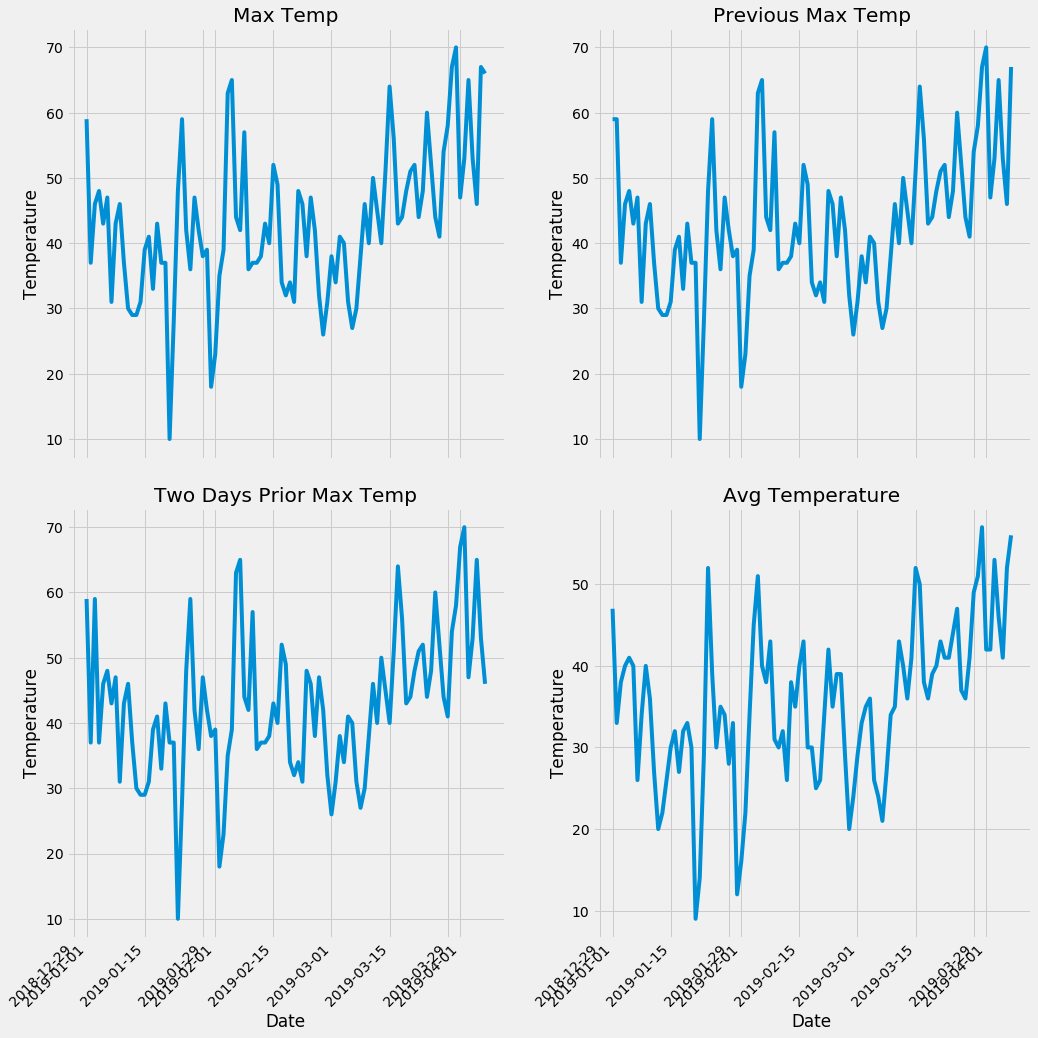

In [538]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,15))
fig.autofmt_xdate(rotation = 45)

# Actual max temperature measurement
ax1.plot(dates, features['Actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# Avg Estimate
ax4.plot(dates, features['TAVG'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Avg Temperature')

plt.tight_layout(pad=2)

## 3.Data Preparation

### One-Hot Encoding

One hot encoding takes a **categorical variable** and re-encodes it as a **binary variable** in multiple dimensions. You'll see this often in Machine Learning algorithms.

| week |
|------|
| Mon  |
| Tue  |
| Wed  |
| Thu  |
| Fri  |

and converts it into:

| Mon | Tue | Wed | Thu | Fri |
|-----|-----|-----|-----|-----|
| 1   | 0   | 0   | 0   | 0   |
| 0   | 1   | 0   | 0   | 0   |
| 0   | 0   | 1   | 0   | 0   |
| 0   | 0   | 0   | 1   | 0   |
| 0   | 0   | 0   | 0   | 1   |

The first step for us is known as one-hot encoding of the data. This process takes categorical variables, such as days of the week and converts it to a numerical representation without an arbitrary ordering.What computers know is numbers and for machine learning we must accommodate them. We could simply map days of the week to numbers 1–7, but this might lead to the algorithm placing more importance on Sunday because it has a higher numerical value. Instead, we change the single column of weekdays into seven columns of binary data. 

In [539]:
# One-hot encode categorical features
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,TAVG,Actual,week_Fri,week_Mon,week_Sat,week_Sun,week_Thu,week_Tue,week_Wed
0,2019,1,1,59,59,47,59,0,0,0,0,0,1,0
1,2019,1,2,37,59,33,37,0,0,0,0,0,0,1
2,2019,1,3,59,37,38,46,0,0,0,0,1,0,0
3,2019,1,4,37,46,40,48,1,0,0,0,0,0,0
4,2019,1,5,46,48,41,43,0,0,1,0,0,0,0


In [540]:
print('Shape of features after one-hot encoding:', features.shape)

Shape of features after one-hot encoding: (97, 14)


### Features and Labels and Convert Data to Arrays

Now, we need to separate the data into the features and targets. The target, also known as the label, is the value we want to predict, in this case the actual max temperature and the features are all the columns the model uses to make a prediction. 

In [541]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict: the actual temperature
labels = np.array(features['Actual'])

# Remove the labels from the features, so we have one table for independent variables to predict the actual temperature
# (axis 1 refers to columns)
features = features.drop('Actual', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)


### Training and Testing Sets

There is one final step of data preparation: splitting data into training and testing sets. During training, we let the model ‘see’ the answers, in this case the actual temperature, so it can learn how to predict the temperature from the features. We expect there to be some relationship between all the features and the target value, and the model’s job is to learn this relationship during training. Then, when it comes time to evaluate the model, we ask it to make predictions on a testing set where it only has access to the features (not the answers)! 

Generally, when training a model, we randomly split the data into training and testing sets to get a representation of all data points.I am setting the random state to 48 which means the results will be the same each time I run the split for reproducible results.

In [542]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 48)

In [543]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (72, 13)
Training Labels Shape: (72,)
Testing Features Shape: (25, 13)
Testing Labels Shape: (25,)


Makre sure you got your dimensions right.

## 4.Establish Baseline

Before we can make and evaluate predictions, we need to establish a baseline, a sensible measure that we hope to beat with our model. If our model cannot improve upon the baseline, then it will be a failure and we should try a different model or admit that machine learning is not right for our problem. The baseline prediction for our case can be the historical max temperature averages. In other words, our baseline is the error we would get if we simply predicted the average max temperature for all days.

In [544]:
# The baseline predictions are historical averages
baseline_preds = test_features[:, feature_list.index('TAVG')]

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'degrees.')

Average baseline error:  7.16 degrees.


## 5.Train Model

We import the random forest regression model from skicit-learn, instantiate the model, and fit (scikit-learn’s name for training) the model on the training data. (Again setting the random state for reproducible results).

In [545]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=48)

# Train the model on training data
rf.fit(train_features, train_labels);

## 6.Make Predictions on Test Data

Our model has now been trained to learn the relationships between the features and the targets. The next step is figuring out how good the model is! To do this we make predictions on the test features (the model is never allowed to see the test answers). We then compare the predictions to the known answers. When performing regression, we need to make sure to use the absolute error because we expect some of our answers to be low and some to be high. We are interested in how far away our average prediction is from the actual value so we take the absolute value (as we also did when establishing the baseline).

In [546]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 3.05 degrees.


We did good because our mean absoute error is less than the average baseline error based on pure historical data :-)

## 7.Determine Performance Metrics

To put our predictions in perspective, we can calculate an accuracy using the mean average percentage error subtracted from 100 %.

In [547]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 92.82 %.


## 8.Improve Model if Necessary

We can create models with different hyperparameters to try to boost performance. The only way to find the best ones
are to try a few and evaluate them! This is the dark art of hyperparameter estimation. I told you that *tree* regression has no hyperparameters, but *forest* regression does!

In [548]:
rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, 
                               min_samples_split = 2, min_samples_leaf = 1)

## 9.Visualize and Interpret Model Results

### Visualizing a Single Decision Tree

In [549]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

import os
# you may have to modify the line below for the MAC. Essentially find the path for the `dot` executable, and add it 
# to your PATH environment variable:
os.environ["PATH"] += os.pathsep + '/usr/local/bin/.'

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree1.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree1.dot')

# Write graph to a png file
graph.write_png('tree1.png'); 

<br />
<center>
<img src = tree1.png width = 1000 />
</center>

In [558]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 7


Smaller tree for visualization.

In [559]:
# Limit depth of tree to 2 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=48)
rf_small.fit(train_features, train_labels)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree1.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree1.dot')

graph.write_png('small_tree1.png');

<br />
<center>
<img src = small_tree1.png width = 1000 />
</center>

Based solely on this tree, we can make a prediction for any new data point. Let’s take an example of making a prediction for Mondsy, April 8th, 2019. The (actual) variables are: temp_2 = 67, temp_1 = 69, TAVG = 56. We start at the root node and the first answer is False because TAVG ≤ 37.0. We move to the right and encounter the second question, which is also False as average greater than 44.0. Move down to the right and on to the third and final question which is True because TAVG is lesser than 56.5. Therefore, we conclude that our estimate for the maximum temperature is 64 degrees as indicated by the value in the leaf node

## 10.Variable Importances

Remember that decision trees gives yields a ranking of decisive parameters for classification.

In [552]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TAVG                 Importance: 0.92
Variable: temp_2               Importance: 0.02
Variable: temp_1               Importance: 0.02
Variable: month                Importance: 0.01
Variable: day                  Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thu             Importance: 0.0
Variable: week_Tue             Importance: 0.0
Variable: week_Wed             Importance: 0.0


Here we see that the avg temperature is *the most important forecasting parameter*.The metric used by the random forest algorithm is information gain.

### Model with Two Most Important Features

Let's build a new model, with just the two most important forecasting parameters: Temperature one day ago and historical baseline.

In [553]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('temp_1'), feature_list.index('TAVG')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.32 degrees.
Accuracy: 92.13 %.


You can see that it is only *very slightly worse* than the full model! Sometimes, a simple model is better than a complicated model if the error difference is small.

### Visualizations of Variable importances

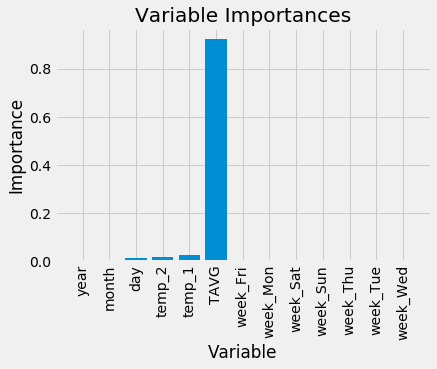

In [554]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

## 11. Predictions and Actual Values

Let's plot predictions over labels, using our test dataset.

In [555]:
# Dates of training values
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'Actual': labels})

# Dates of predictions
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions}) 

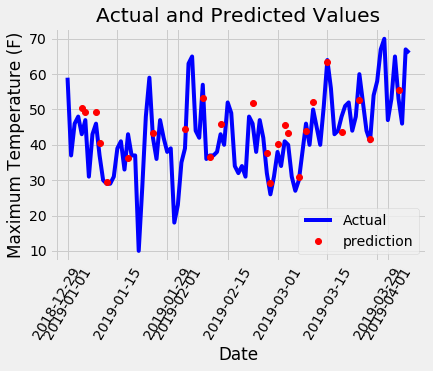

In [556]:
# Plot the actual values
plt.plot(true_data['date'], true_data['Actual'], 'b-', label = 'Actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');


### Targets and Data Visualization

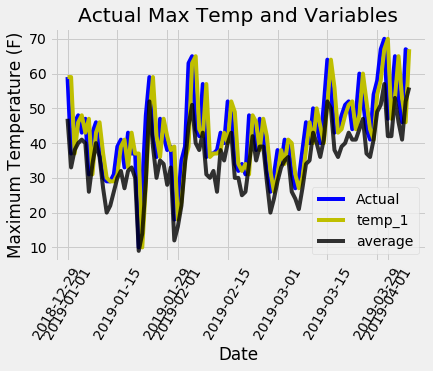

In [557]:
# Make the data accessible for plotting
true_data['temp_1'] = features[:, feature_list.index('temp_1')]
true_data['TAVG'] = features[:, feature_list.index('TAVG')]
#true_data['friend'] = features[:, feature_list.index('friend')]

# Plot all the data as lines
plt.plot(true_data['date'], true_data['Actual'], 'b-', label  = 'Actual', alpha = 1.0)
plt.plot(true_data['date'], true_data['temp_1'], 'y-', label  = 'temp_1', alpha = 1.0)
plt.plot(true_data['date'], true_data['TAVG'], 'k-', label = 'average', alpha = 0.8)
#plt.plot(true_data['date'], true_data['friend'], 'r-', label = 'friend', alpha = 0.3)

# Formatting plot
plt.legend(); plt.xticks(rotation = '60');

# Lables and title
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');